In [1]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt

import urllib

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [7]:
# Setup URL to Data File
url = "https://raw.githubusercontent.com/luisroque/deep-learning-articles/main/data/eng-por.txt"

data = []
with urllib.request.urlopen(url) as raw_data:
    for line in raw_data:
        data.append(line.decode("utf-8").split('\t')[0:2])
data = np.array(data)

data.shape

In [13]:
# Subset? - All of the data will take some time...
n_seq = data.shape[0]
n_seq = 100
data = data[0:n_seq]
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop

print(f"max_length = ${max_length}")
print(f"data[0] => ${data[0]}")

max_length = $23
data[0] => $['Run.' 'Corra!']


In [14]:
# Setup
i_to_c_eng = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_eng = {i_to_c_eng[i]:i for i in range(len(i_to_c_eng))}
i_to_c_eng[1] = i_to_c_eng[2] = ''

i_to_c_por = ['','<START>','<STOP>'] + list({char for word in data[:,1] for char in word})
c_to_i_por = {i_to_c_por[i]:i for i in range(len(i_to_c_por))}
i_to_c_por[1] = i_to_c_por[2] = ''


In [18]:
def encode_seq(x, mapping, max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
    
def decode_seq(x, mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [19]:
data[0]


array(['Run.', 'Corra!'], dtype='<U184')

In [20]:
data[0,0]

'Run.'

In [26]:
temp = encode_seq(data[0,0],c_to_i_eng,max_length)

print(temp)

[1, 17, 36, 3, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
decode_seq(temp, i_to_c_eng)

'Run.'

In [27]:
data[0,1]

'Corra!'

In [28]:
temp = encode_seq(data[0,1],c_to_i_por,max_length)

print(temp)

[1, 27, 23, 40, 40, 31, 49, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
decode_seq(temp, i_to_c_por)

'Corra!'

In [30]:
# Setup
X = np.vstack([encode_seq(x, c_to_i_eng, max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x, c_to_i_por, max_length) for x in data[:,1]])

enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train


array([[ 1, 17, 36, ...,  0,  0,  0],
       [ 1, 35, 18, ...,  0,  0,  0],
       [ 1, 29, 36, ...,  0,  0,  0],
       ...,
       [ 1,  9, 24, ...,  0,  0,  0],
       [ 1, 12, 13, ...,  0,  0,  0],
       [ 1, 14, 16, ...,  0,  0,  0]])

In [31]:
# Setup
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[ 1, 27, 23, ...,  0,  0,  0],
       [ 1, 30, 31, ...,  0,  0,  0],
       [ 1, 50, 42, ...,  0,  0,  0],
       ...,
       [ 1, 10, 24, ...,  0,  0,  0],
       [ 1, 15, 16, ...,  0,  0,  0],
       [ 1,  6, 42, ...,  0,  0,  0]])

In [33]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[27, 23, 40, ...,  0,  0,  0],
       [30, 31, 18, ...,  0,  0,  0],
       [50, 42, 36, ...,  0,  0,  0],
       ...,
       [10, 24, 38, ...,  0,  0,  0],
       [15, 16, 31, ...,  0,  0,  0],
       [ 6, 42,  7, ...,  0,  0,  0]])

In [36]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

print("----")

print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(80, 23)
(80, 22)
(80, 22)
----
(20, 23)
(20, 22)
(20, 22)


In [37]:
len(i_to_c_eng)

In [38]:
len(i_to_c_por)

In [39]:
enc_x_train.shape[1:]

In [40]:
class RecurrentResidual(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 bidirectional = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(latent_size)
        self.rnn_layer = torch.nn.RNN(latent_size,
                                      latent_size // 2 if bidirectional else latent_size,
                                      bidirectional=bidirectional,
                                      batch_first=True)
    def forward(self, x):
        return x + self.rnn_layer(self.layer_norm(x))[0]

class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 4,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size, True) for _ in range(n_layers)
        ])
        
    def forward(self, x):
        y = x
        y = self.embedding(y)
        y = self.dropout(y)
        y = self.rnn_layers(y)[:,-1]
        return y


In [41]:
enc_x_train[0:5].shape

In [42]:
enc_net = EncoderNetwork(num_tokens=len(i_to_c_eng))
summary(enc_net,input_data=torch.Tensor(enc_x_train[0:5]).long())

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 64]                   --
├─Embedding: 1-1                         [5, 23, 64]               2,816
├─Dropout1d: 1-2                         [5, 23, 64]               --
├─Sequential: 1-3                        [5, 23, 64]               --
│    └─RecurrentResidual: 2-1            [5, 23, 64]               --
│    │    └─LayerNorm: 3-1               [5, 23, 64]               128
│    │    └─RNN: 3-2                     [5, 23, 64]               6,272
│    └─RecurrentResidual: 2-2            [5, 23, 64]               --
│    │    └─LayerNorm: 3-3               [5, 23, 64]               128
│    │    └─RNN: 3-4                     [5, 23, 64]               6,272
│    └─RecurrentResidual: 2-3            [5, 23, 64]               --
│    │    └─LayerNorm: 3-5               [5, 23, 64]               128
│    │    └─RNN: 3-6                     [5, 23, 64]               6,272


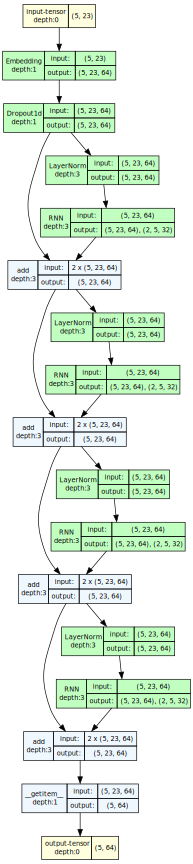

In [43]:
model_graph = draw_graph(enc_net,
                         input_data = torch.Tensor(enc_x_train[0:5]).long(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])
model_graph.visual_graph